# Notebook to clean station data

Within this notebook each of the stations is loaded singularily.

Each station a a specific z value and temporal filtering is applied to exclude unreliable measurements


In [ ]:
import pandas as pd
import geopandas as gpd


#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 13)
#---------------------------------------------------

### Helper funsiton to drop statistical outliers

In [3]:
from scipy import stats

def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
    
    return df

### Load original field dataset

In [4]:
# read data
df = pd.read_csv('/home/vollrath/Indonesia_sm/Combined_sipalaga_all.csv', delimiter=';')
print(f'We have {len(df)} records')

# exclude smm from columns
cols = ['station', 'index', 'location', 'province', 'lon', 'lat', 'GWL_max', 'GWL_min', 'GWL_rata', 'SM_max', 'SM_min', 'SM_rata', 'Total']
print(f'We have {len(df[cols].dropna())} records afte dropping all NaNs')
# and drop nans
df_no_nans = df[cols].dropna()

print(f'We have {len(df_no_nans.station.unique())} different stations for Soil Moisture Estimates')

df_no_nans['index'] = pd.to_datetime(df_no_nans['index'], format='%d/%m/%Y')
df_no_nans = df_no_nans.set_index('index').dropna()

We have 39787 records
We have 30316 records afte dropping all NaNs
We have 89 different stations for Soil Moisture Estimates


### Iterative function to plot each station

z, j and k are the values ot exclude the data, where:
- z is the z-value for statistical outliers
- j is the start measurement
- k is the en dmesuremtn (end - k) for excluding k-last measurements 

In [393]:
for i, station in enumerate(df_no_nans.station.unique()):
    if i < 89:
        continue
        
    z, j, k = 3, 1, 0
    
    #df = df_no_nans[['station', 'province', 'location', 'GWL_rata']][df_no_nans.station == station]
    df = df_no_nans[df_no_nans.station == station]
    y = df['GWL_rata']
    removed_outliers = y.between(y.quantile(.05), y.quantile(.95))
    removed_z = np.abs(stats.zscore(y)) < z
    #print(removed_outliers)
    df_clean = df[removed_outliers]
    df_z = df[removed_z]
    print(len(df), len(df_clean), len(df_z))
    df['GWL_rata'].plot()
    #df_z['GWL_rata'][df_z['GWL_rata'] > -1.5].plot()
    df_z['GWL_rata'][j:].plot()
    df_z[j:].to_pickle(f'/home/vollrath/Indonesia_sm/cleaned_station_data/{i}.{station}.pickle')
    break
    df_out = drop_numerical_outliers(df, 5)  
    print(station, len(df) - len(df_out))
    if i == 0:
        
        df_clean = df_out
    else:
        df_clean = df_clean.append(df_out)

### merge all single pickel files into one for a cleaned dataset

stations to exlcude: 30, (32), (33), (56), (69), 88

In [405]:
for i, file in enumerate(Path(f'/home/vollrath/Indonesia_sm/cleaned_station_data/').glob(f'*pickle')):
    print(i, file)
    if i == 0:
        d = pd.read_pickle(file)
    else:
        d = d.append(pd.read_pickle(file))
    
    

0 /home/vollrath/Indonesia_sm/cleaned_station_data/83.brg6.pickle
1 /home/vollrath/Indonesia_sm/cleaned_station_data/86.kalbar1.pickle
2 /home/vollrath/Indonesia_sm/cleaned_station_data/11.BRG_150710_03.pickle
3 /home/vollrath/Indonesia_sm/cleaned_station_data/49.BRG_621107_05.pickle
4 /home/vollrath/Indonesia_sm/cleaned_station_data/34.BRG_621101_01.pickle
5 /home/vollrath/Indonesia_sm/cleaned_station_data/53.BRG_621108_01.pickle
6 /home/vollrath/Indonesia_sm/cleaned_station_data/45.BRG_621107_01.pickle
7 /home/vollrath/Indonesia_sm/cleaned_station_data/38.BRG_621103_03.pickle
8 /home/vollrath/Indonesia_sm/cleaned_station_data/78.brg19.pickle
9 /home/vollrath/Indonesia_sm/cleaned_station_data/32.BRG_620801_01.pickle
10 /home/vollrath/Indonesia_sm/cleaned_station_data/15.BRG_610207_01.pickle
11 /home/vollrath/Indonesia_sm/cleaned_station_data/36.BRG_621103_01.pickle
12 /home/vollrath/Indonesia_sm/cleaned_station_data/76.brg17.pickle
13 /home/vollrath/Indonesia_sm/cleaned_station_data/4

In [407]:
d.to_pickle('/home/vollrath/Indonesia_sm/cleaned_station_data/cleaned_field_stations.pickle')

### some additonal code following, not important

<AxesSubplot:xlabel='index'>

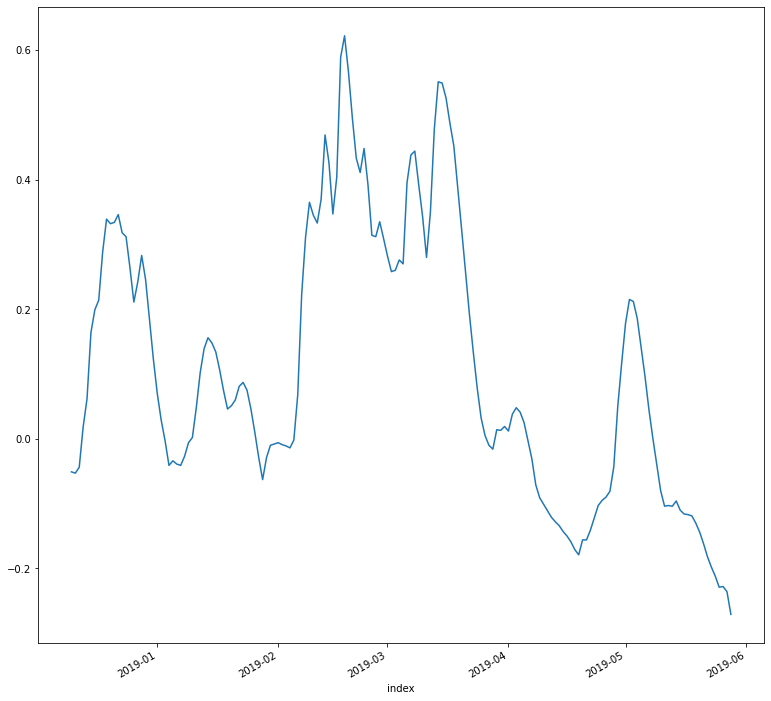

In [242]:

from pathlib import Path
i = 54
d = pd.read_pickle(list(Path(f'/home/vollrath/Indonesia_sm/cleaned_station_data/').glob(f'{i}*pickle'))[0])
d['GWL_rata'].plot()

In [ ]:
stat_high = stations.stasiun[(stations['corr_sm'] >= 0.5)]
#df_no_nans = df_no_nans[df_no_nans.station.isin(stat_high)].copy()

for province in df_no_nans.province.unique():
    
    df_to_plot = df_no_nans[df_no_nans.province == province]
    sns.set(font_scale = 2)
    ax = sns.boxplot(x='station', y='SM_rata', data=df_to_plot)
    plt.xticks(rotation=45, horizontalalignment='right', fontsize='small')
    plt.yticks(horizontalalignment='right', fontsize='small')
    plt.title(province)
    plt.savefig(f'/home/vollrath/Indonesia_sm/figures/groundstations/sm/{province}.png')
    plt.close()
    

In [ ]:
df_no_nans.to_date

In [ ]:
df_no_nans['index'] = pd.to_datetime(df_no_nans['index'])
df_no_nans = df_no_nans.set_index('index').dropna()

In [ ]:
df_no_nans.GWL_rata[df_no_nans.station == 'BRG_621103_05'].plot()

In [ ]:
stations[(stations['corr_sm'] >= 0.5)].sort_values('corr_gwl', ascending=False)